In [61]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
import pandas as pd
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline


In [62]:
path = ""
image_path = os.path.join(path, '../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/')
mask_path = os.path.join(path, "../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/")

image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path + i for i in image_list]
mask_list = [mask_path + i for i in mask_list]

../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_161.png
../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_161.png


Text(0.5, 1.0, 'Segmentation')

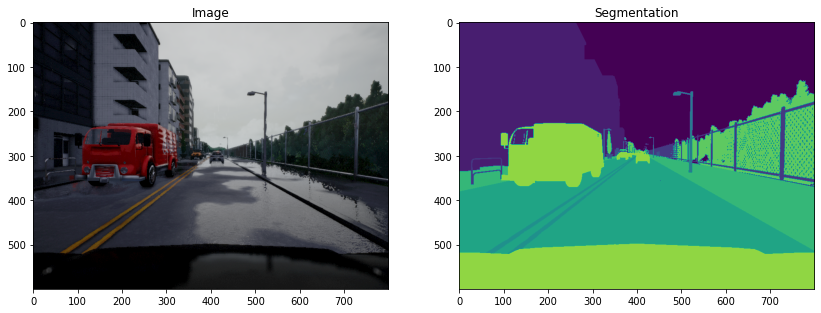

In [63]:
N = 2
print(image_list[N])
img = imageio.imread(image_list[N])
print(mask_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [64]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path[1])

tf.Tensor(b'../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png', shape=(), dtype=string)
tf.Tensor(b'../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_010.png', shape=(), dtype=string)


In [65]:
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))

for img, mask in dataset.take(2):
    print(img, mask)

tf.Tensor(b'../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png', shape=(), dtype=string) tf.Tensor(b'../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png', shape=(), dtype=string)
tf.Tensor(b'../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F2-90.png', shape=(), dtype=string) tf.Tensor(b'../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F2-90.png', shape=(), dtype=string)


In [66]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [67]:
@tf.function
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
    
    return img, mask

@tf.function
def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method = "nearest")
    input_mask = tf.image.resize(mask, (96, 128), method = "nearest") 
    
    input_image = input_image / 255
    
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)


**Unet Architecture**

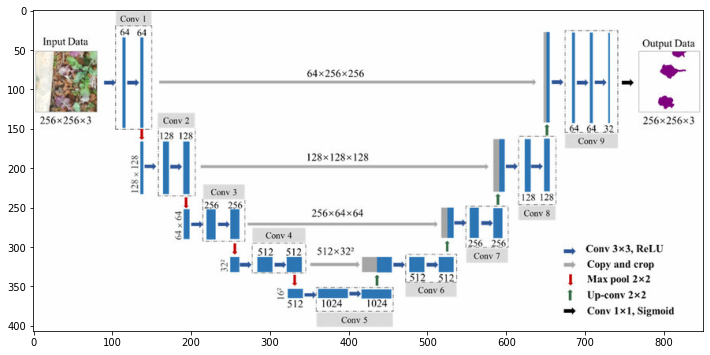

In [68]:
img = tf.io.read_file("../input/unet-architecture/unet_architecture.png")
img = tf.image.decode_png(img, channels=3)
plt.figure(1, figsize = (12, 25))
plt.imshow(img)


#### Convolution Block for features extraction

In [69]:
def conv_block(inputs=None, n_filters = 32, dropout_prob = 0, max_pooling = True):
    
    conv = Conv2D(n_filters, kernel_size = 3, activation = "relu", 
                  padding = "same", kernel_initializer = "he_normal")(inputs)
    
    conv = Conv2D(n_filters, kernel_size = 3, activation = "relu", 
                  padding = "same", kernel_initializer = "he_normal")(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2, 2))(conv)
    else:
        next_layer = conv
    
    skip_connection = conv
    
    return next_layer, skip_connection

#### Upsampling (Transpose Convolution) for segmentation

In [70]:
def upsampling_block(expansive_block, contractive_input, n_filters = 32):
    up = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = "same")(expansive_block)
    conv = concatenate([up, contractive_input],axis = 3)
    
    conv = Conv2D(n_filters, kernel_size = 3, activation = "relu", 
                  padding = "same", kernel_initializer = "he_normal")(conv)
    
    conv = Conv2D(n_filters, kernel_size = 3, activation = "relu", 
                  padding = "same", kernel_initializer = "he_normal")(conv)
    
    
    return conv

In [71]:
def unet_model(input_size=(96, 128, 3), n_filters= 32, n_classes = 23):
    inputs = Input(input_size)
    conv_block1 = conv_block(inputs, n_filters)
    conv_block2 = conv_block(conv_block1[0], n_filters * 2)
    conv_block3 = conv_block(conv_block2[0], n_filters * 4)
    conv_block4 = conv_block(conv_block3[0], n_filters * 8, dropout_prob=0.3)
    conv_block5 = conv_block(conv_block4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)
    
    upsampling_block1 = upsampling_block(conv_block5[0], conv_block4[1], n_filters * 8)
    upsampling_block2 = upsampling_block(upsampling_block1, conv_block3[1], n_filters * 4)
    upsampling_block3 = upsampling_block(upsampling_block2, conv_block2[1], n_filters * 2)
    upsampling_block4 = upsampling_block(upsampling_block3, conv_block1[1], n_filters)
    
    conv9 = Conv2D(n_filters, 3, padding="same",
                  activation="relu", kernel_initializer= "he_normal")(upsampling_block4)
    
    conv10 = Conv2D(n_classes, 1, padding="same")(conv9)
    
    
    model = tf.keras.Model(inputs, conv10)
    
    return model    

In [72]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [73]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 96, 128, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_61[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 48, 64, 32)   0           conv2d_62[0][0]                  
____________________________________________________________________________________________

#### Compile model
Optimizer = Adam \
Loss = SparseCategorical CrossEntropy With Logits \
Metrics = Accuracy

In [74]:
unet.compile(optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

**Create image display function**

In [75]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    
    plt.show()

(96, 128, 1)


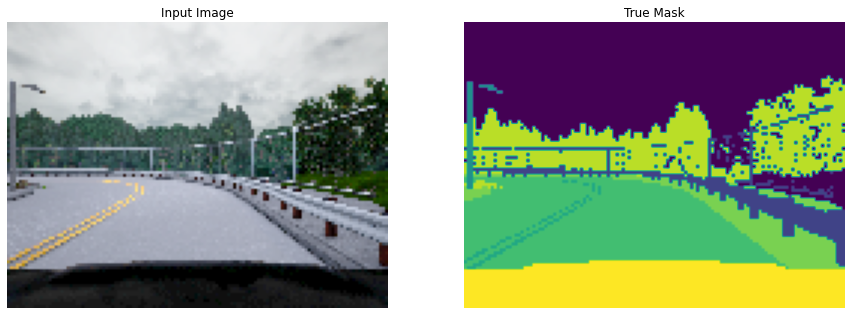

In [76]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [77]:
EPOCHS = 80
VAL_SUBSPLITS =5
BUFFER_SIZE = 500
BATCH_SIZE =32

# preprocess_image_ds=  preprocess_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS, use_multiprocessing=True)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/80
32/32 [==============================] - 23s 391ms/step - loss: 4.0509 - accuracy: 0.1775
Epoch 2/80
32/32 [==============================] - 2s 69ms/step - loss: 2.1985 - accuracy: 0.2423
Epoch 3/80
32/32 [==============================] - 2s 69ms/step - loss: 1.6125 - accuracy: 0.3619
Epoch 4/80
32/32 [==============================] - 2s 69ms/step - loss: 0.9911 - accuracy: 0.6564
Epoch 5/80
32/32 [==============================] - 2s 69ms/step - loss: 0.8371 - accuracy: 0.7038
Epoch 6/80
32/32 [==============================] - 2s 70ms/step - loss: 0.7754 - accuracy: 0.7201
Epoch 7/80
32/32 [==============================] - 2s 70ms/step - loss: 0.7396 - accuracy: 0.7324
Epoch 8/80
32/32 [==============================] - 2s 70ms/step - loss: 0.7228 - accuracy: 0.7379
Epoch 9/80
32/32 [==============================] - 2s 69ms/step - loss: 0.6389 - acc

**Let's see our predicted result**

(32, 96, 128, 1)


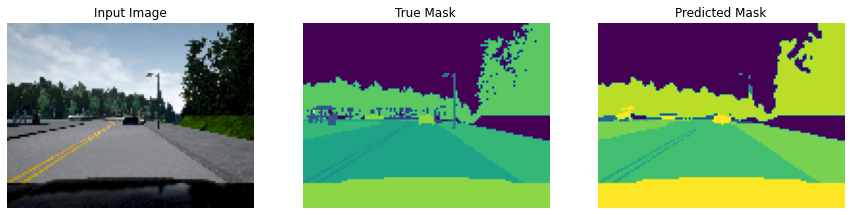

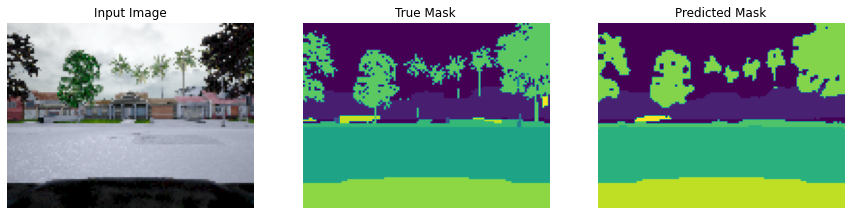

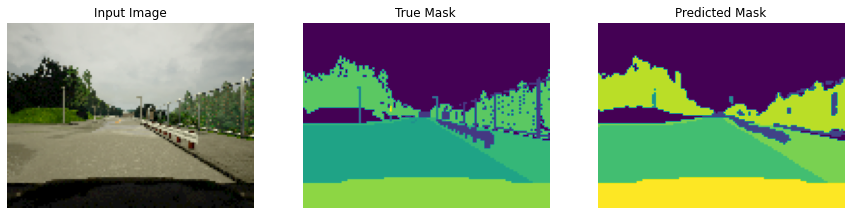

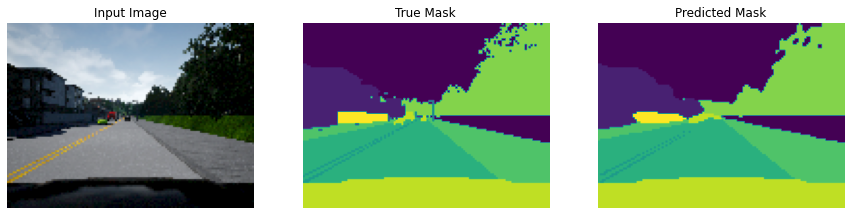

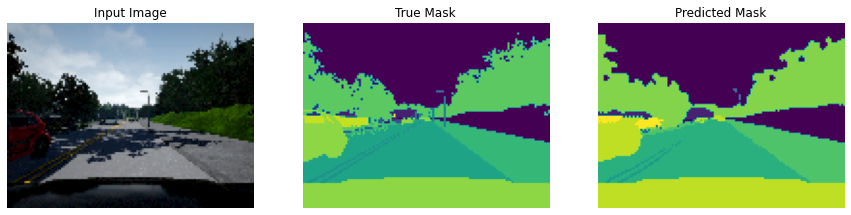

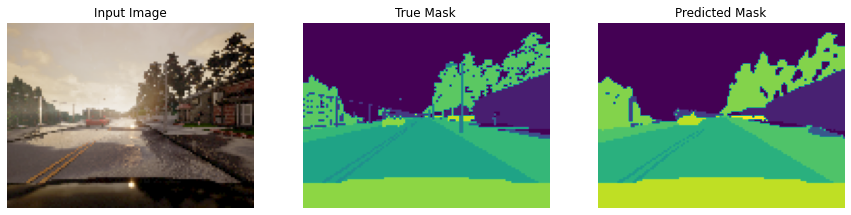

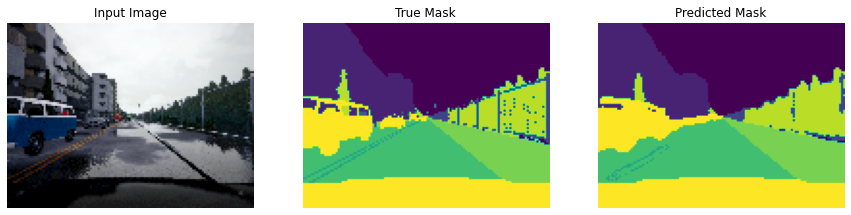

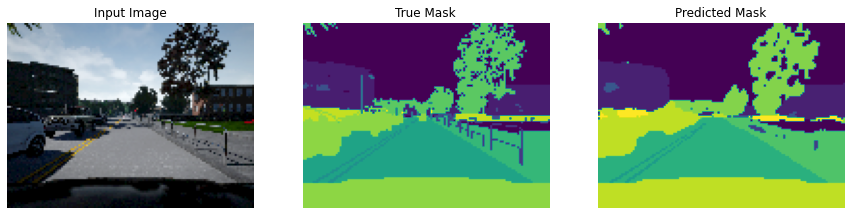

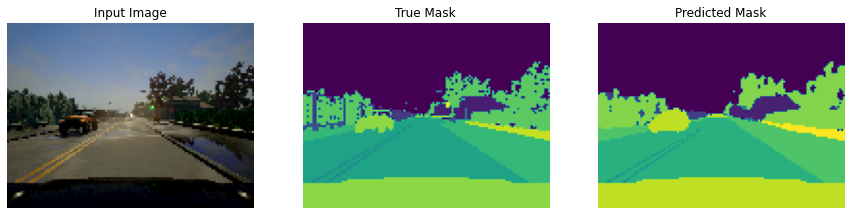

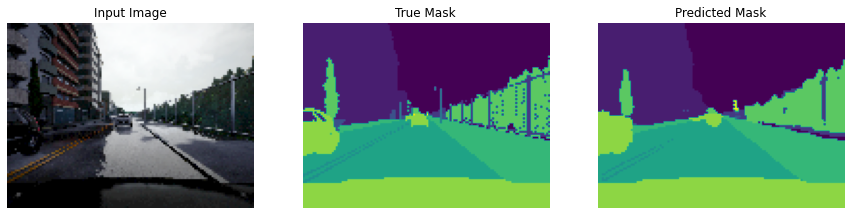

In [79]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
    predicted_mask = tf.argmax(unet.predict(sample_image), axis = -1)[:, :, :, tf.newaxis]
    print(predicted_mask.shape)
    
    for i in range(10):
        display([sample_image[i], sample_mask[i], predicted_mask[i]])
        


### Testing Our Trained Model
1. Take data from another folder
2. Preprocess the data
3. Create test dataset loader
4. Model evalution

In [86]:
path = ""
dev_image_path = os.path.join(path, '../input/lyft-udacity-challenge/dataC/dataC/CameraRGB/')
dev_mask_path = os.path.join(path, "../input/lyft-udacity-challenge/dataC/dataC/CameraSeg/")

dev_image_list = os.listdir(dev_image_path)
dev_mask_list = os.listdir(dev_mask_path)
dev_image_list = [dev_image_path + i for i in dev_image_list]
dev_mask_list = [dev_mask_path + i for i in dev_mask_list]


dev_image_list[:2], dev_mask_list[:2]

(['../input/lyft-udacity-challenge/dataC/dataC/CameraRGB/F69-95.png',
  '../input/lyft-udacity-challenge/dataC/dataC/CameraRGB/F8-24.png'],
 ['../input/lyft-udacity-challenge/dataC/dataC/CameraSeg/F69-95.png',
  '../input/lyft-udacity-challenge/dataC/dataC/CameraSeg/F8-24.png'])

In [87]:
dev_image_filenames = tf.constant(dev_image_list)
dev_mask_filenames = tf.constant(dev_mask_list)

dev_dataset = tf.data.Dataset.from_tensor_slices((dev_image_filenames, dev_mask_filenames))


dev_image_ds = dataset.map(process_path)
dev_processed_image_ds = image_ds.map(preprocess)
test_dataset = dev_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(32, 96, 128, 1)


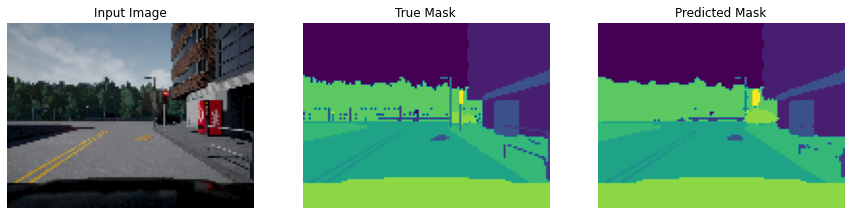

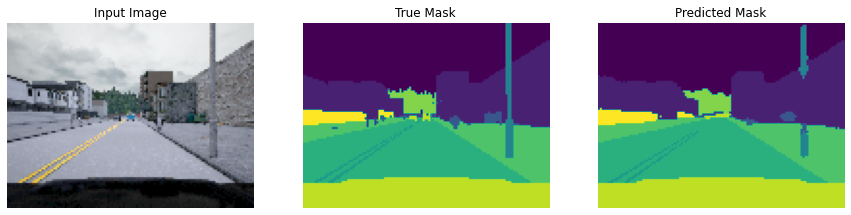

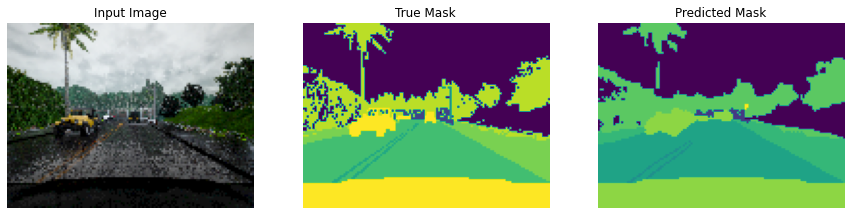

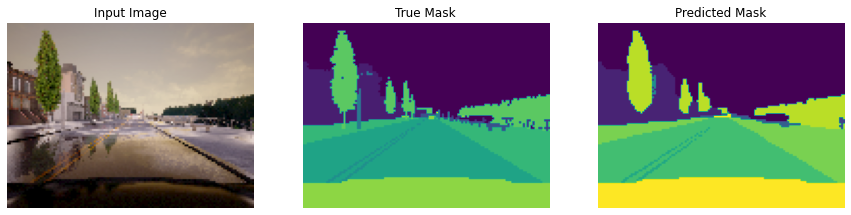

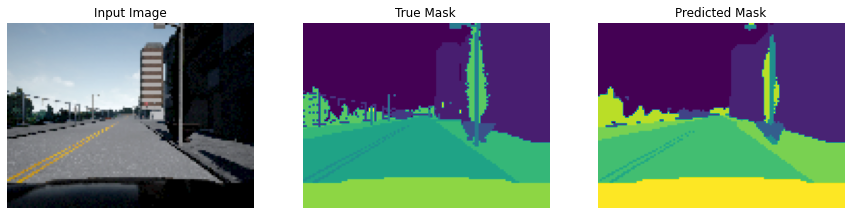

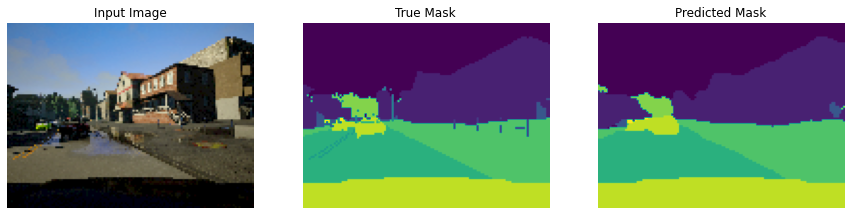

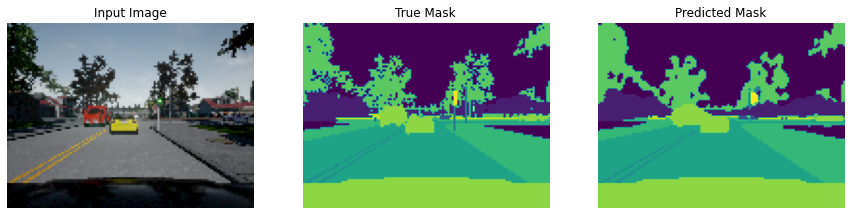

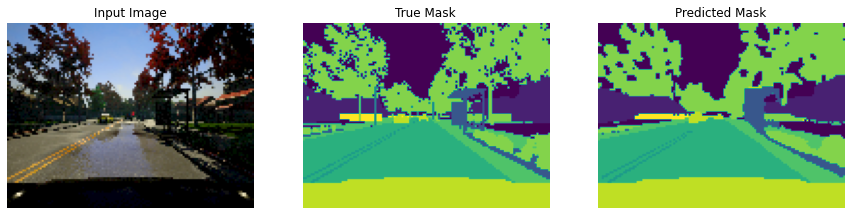

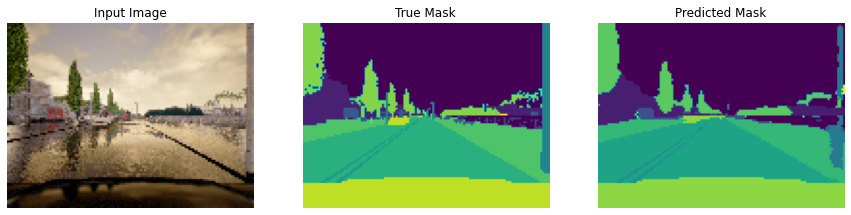

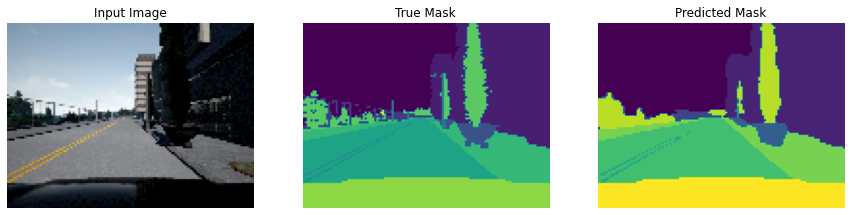

2021-09-17 02:44:44.367845: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [88]:

for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask
    predicted_mask = tf.argmax(unet.predict(sample_image), axis = -1)[:, :, :, tf.newaxis]
    print(predicted_mask.shape)
    
    for i in range(10):
        display([sample_image[i], sample_mask[i], predicted_mask[i]])

In [89]:
unet.evaluate(test_dataset, use_multiprocessing= True)

32/32 [==============================] - 20s 325ms/step - loss: 0.1277 - accuracy: 0.9527


[0.12771569192409515, 0.9526828527450562]